In [15]:
import csv
import pandas as pd
from sklearn.model_selection import train_test_split

# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import RobustScaler
plt.style.use("bmh")

# Technical Analysis library
import FinanceDataReader as fdr
#import ta

# Neural Network library
import tensorflow as tf
import tensorflow_probability as tfp
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.layers import Activation
from keras.optimizers import Adam
from tensorflow import keras
from sklearn.utils import shuffle
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from tensorflow.python.keras.models import load_model

In [5]:
df = pd.read_csv("top50-Stock_LogReturn.csv", index_col="Date")
train, test = train_test_split(df, test_size=0.2, shuffle=False)

train_len = len(train)
test_len = len(test)

xc_train = np.empty((train_len - 80, 60, 50))
xf_train = np.empty((train_len - 80, 20, 50))
xc_test = np.empty((test_len - 80, 60, 50))
xf_test = np.empty((test_len - 80, 20, 50))

for i in range(train_len - 80):
    temp_xc_train = train[i : i+60]
    temp_xf_train = train[i+60 : i+80]

    xc_train[i] = temp_xc_train
    xf_train[i] = temp_xf_train

for i in range(test_len - 80):
    temp_xc_test = test[i : i+60]
    temp_xf_test = test[i+60 : i+80]

    xc_test[i] = temp_xc_test
    xf_test[i] = temp_xf_test

# 월간 수익률 정도의 스케일로 변환한다
xc_train = xc_train.astype('float32') * 20
xf_train = xf_train.astype('float32') * 20
xc_test = xc_test.astype('float32') * 20
xf_test = xf_test.astype('float32') * 20

N_TIME = xc_train.shape[1]
N_FUTURE = xf_train.shape[1]
N_STOCKS = xf_train.shape[2]

# 학습 데이터는 shuffling 한다.
xc_train, xf_train = shuffle(xc_train, xf_train)

# over confidence를 제어할 조절 변수 정의
GAMMA_CONST = 0.1
REG_CONST = 0.1
SAVE_MODEL = 'Markowitz_network'

# 최적 포트폴리오를 구축할 목표 함수를 정의한다.
# MPN에서는 이 함수를 loss로 이용한다. max(objective) = min(-objective)
# y_true = model.fit()에서 전달된 N_FUTURE일 후의 수익률 (xf_train)이 들어온다.
# y_pred = 마코비츠 네트워크의 출력이 전달된다. (keras 내부 기능)

def markowitz_objective(y_true, y_pred):
    W = y_pred      # 마코비츠 네트워크의 출력
    xf_rtn = y_true
    W = tf.expand_dims(W, axis = 1)
    R = tf.expand_dims(tf.reduce_mean(xf_rtn, axis = 1), axis = 2)
    C = tfp.stats.covariance(xf_rtn, sample_axis=1)

    rtn = tf.matmul(W, R)  
    vol = tf.matmul(W, tf.matmul(C, tf.transpose(W, perm = [0, 2, 1]))) * GAMMA_CONST
    reg = tf.reduce_sum(tf.square(W), axis = -1) * REG_CONST
    objective = rtn - vol - reg
    
    return -tf.reduce_mean(objective, axis=0)

model =  tf.keras.models.load_model('Markowitz_network_overfitting.h5', custom_objects={'markowitz_objective': markowitz_objective})

1/1 [==============================] - 1s 627ms/step


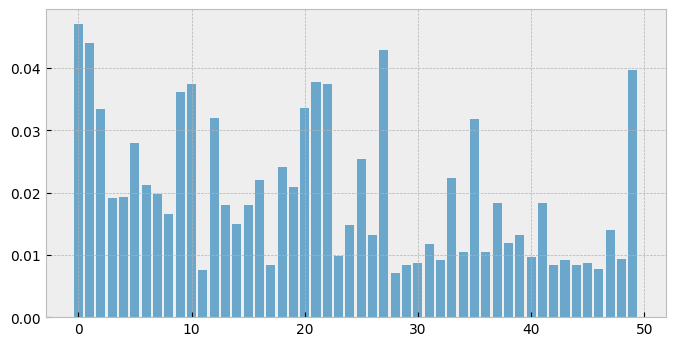

In [6]:
# 최적 포트폴리오 결과 조회용 코드

def check_w(n = 0):
    plt.figure(figsize=(8, 4))
    y_pred = model.predict(xc_test[n].reshape(1, N_TIME, N_STOCKS))[0]
    plt.bar(np.arange(N_STOCKS), y_pred, alpha = 0.7)
    plt.show()

check_w(0)

In [95]:
len(test[-973:].index[idx])

49

In [97]:
N_TIME = xc_test.shape[1]
N_FUTURE = xf_test.shape[1]
N_STOCKS = xf_test.shape[2]

# 저장된 Markowitz 모델을 가져온다.
SAVE_MODEL = 'Markowitz_network_overfitting.h5'
model = load_model(SAVE_MODEL, compile = False)
model.summary()

# 백 테스트를 수행한다.
prt_value = [2905.969971]   # portfolio의 초기 value
crp_value = [2905.969971]   # CRP의 초기 value
w_crp = np.ones(N_STOCKS) / N_STOCKS   # CRP 비율 (균등 비율)

w_history = []
for i in range(0, xc_test.shape[0], N_FUTURE):
    # 이 시점에 각 종목을 w_prt 비율대로 매수한다.
    # 학습할 때 월간 수익률로 변환했으므로, 여기서도 변환해야 한다.
    x = xc_test[i][np.newaxis,:,:] * 20
    w_prt = model.predict(x)[0]
    w_history.append(w_prt)

    # 다음 기간의 누적 수익률
    m_rtn = np.sum(xf_test[i], axis = 0) / 20
 
    # 누적 수익률과 w_prt (W)로 포트폴리오의 수익률을 계산한다.
    prt_value.append(prt_value[-1] * np.exp(np.dot(w_prt, m_rtn)))
    crp_value.append(crp_value[-1] * np.exp(np.dot(w_crp, m_rtn)))

# 평가 시점의 날짜를 발췌한다.
idx = np.arange(0, xc_test.shape[0], N_FUTURE)

# 벤치마크를 위한 S&P500 정의
us500 = fdr.DataReader('US500', '2002-01-01', '2022-12-01')\
    ['Adj Close'][-973:][idx]

# Markowitz 성과와 CRP 성과를 데이터 프레임에 기록해 둔다.
perf_df = pd.DataFrame({'crp':crp_value, 'markowitz':prt_value, 'S&P500':us500})

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 60, 50)]          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_4 (Dense)              (None, 50)                3250      
_________________________________________________________________
activation_4 (Activation)    (None, 50)                0         
Total params: 32,690
Trainable params: 32,690
Non-trainable params: 0
_________________________________________________________________


IndexError: positional indexers are out-of-bounds

In [84]:
len(xc_test)

973

In [83]:
idx

array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240,
       260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500,
       520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 760,
       780, 800, 820, 840, 860, 880, 900, 920, 940, 960])

In [79]:
us500

Date
2018-09-26    2905.969971
2018-10-24    2656.100098
2018-11-21    2649.929932
2018-12-21    2416.620117
2019-01-23    2638.699951
2019-02-21    2774.879883
2019-03-21    2854.879883
2019-04-18    2905.030029
2019-05-17    2859.530029
2019-06-17    2889.669922
2019-07-16    3004.040039
2019-08-13    2926.320068
2019-09-11    3000.929932
2019-10-09    2919.399902
2019-11-06    3076.780029
2019-12-05    3117.429932
2020-01-06    3246.280029
2020-02-04    3297.590088
2020-03-04    3130.120117
2020-04-01    2470.500000
2020-04-30    2912.429932
2020-05-29    3044.310059
2020-06-26    3009.050049
2020-07-27    3239.409912
2020-08-24    3431.280029
2020-09-22    3315.570068
2020-10-20    3443.120117
2020-11-17    3609.530029
2020-12-16    3701.169922
2021-01-15    3768.250000
2021-02-16    3932.590088
2021-03-16    3962.709961
2021-04-14    4124.660156
2021-05-12    4063.040039
2021-06-10    4239.180176
2021-07-09    4369.549805
2021-08-06    4436.520020
2021-09-03    4535.430176
2021-10

In [75]:
us500 = fdr.DataReader('US500', '2002-01-01', '2022-12-01')\
    ['Adj Close'][test.index[idx]]
us500_value = us500 / us500[0] * 10000

In [76]:
us500

Date
2018-09-26    2905.969971
2018-10-24    2656.100098
2018-11-21    2649.929932
2018-12-21    2416.620117
2019-01-23    2638.699951
2019-02-21    2774.879883
2019-03-21    2854.879883
2019-04-18    2905.030029
2019-05-17    2859.530029
2019-06-17    2889.669922
2019-07-16    3004.040039
2019-08-13    2926.320068
2019-09-11    3000.929932
2019-10-09    2919.399902
2019-11-06    3076.780029
2019-12-05    3117.429932
2020-01-06    3246.280029
2020-02-04    3297.590088
2020-03-04    3130.120117
2020-04-01    2470.500000
2020-04-30    2912.429932
2020-05-29    3044.310059
2020-06-26    3009.050049
2020-07-27    3239.409912
2020-08-24    3431.280029
2020-09-22    3315.570068
2020-10-20    3443.120117
2020-11-17    3609.530029
2020-12-16    3701.169922
2021-01-15    3768.250000
2021-02-16    3932.590088
2021-03-16    3962.709961
2021-04-14    4124.660156
2021-05-12    4063.040039
2021-06-10    4239.180176
2021-07-09    4369.549805
2021-08-06    4436.520020
2021-09-03    4535.430176
2021-10

<AxesSubplot: xlabel='Date'>

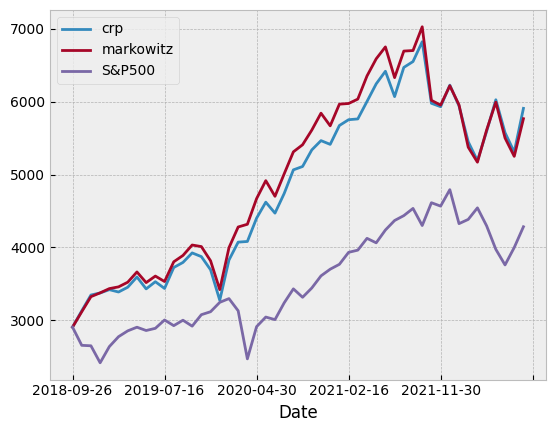

In [78]:
perf_df.plot()